In [4]:
# !pip install torchvision

In [12]:
import torch

In [13]:
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomAffine

In [34]:
## shift
shift_min = RandomAffine(degrees = 0, translate = (0.1, 0.1))
shift_max = RandomAffine(degrees = 0, translate = (0.2, 0.2))

### Dataset

In [ ]:
training_data = datasets.MNIST(
    root="Mnist_data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [263]:

n1 = 10000 # To reduce the traning time
n2 = 12000
x_train = training_data.data[:n1].float().unsqueeze(1)  # [ B, C, H, W]
y_train = training_data.targets[:n1]

x_test = training_data.data[n1:n2].float().unsqueeze(1)
y_test = training_data.targets[n1:n2]

print("Training data :",x_train.shape,f'\nTesting data: {y_train.shape}')

Training data : torch.Size([10000, 1, 28, 28]) 
Testing data: torch.Size([10000])


In [107]:
import matplotlib.pyplot as plt

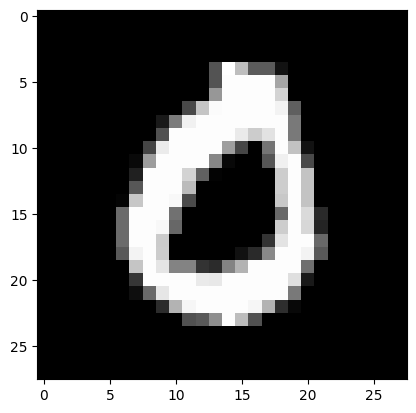

In [269]:
idx = torch.randint(0,n1, (1,))[0]
plt.imshow(x_train[idx][0], cmap='gray')

### model building

In [247]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6760,10)
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        self.map = x
        x = self.flatten(x)
        x = self.fc1(x)
        return x
        

class Netv2(nn.Module):
    def __init__(self):
        super(Netv2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.m = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1690,10)
        
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.m(x)
        self.map = x
        x = self.flatten(x)
        x = self.fc1(x)
        return x
        
        

In [289]:
loss_fn = nn.CrossEntropyLoss()

def Train(model):
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    n_epochs = 5
    losses = []
    for epoch in range(n_epochs):
        batch_loss = torch.tensor([])
        for inputs, labels in batch_generator(x_train, y_train, 64):
    
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss = torch.cat((batch_loss, loss.detach().unsqueeze(0)), dim=0)
        losses.append(batch_loss.mean().item())    
    plt.plot(losses)

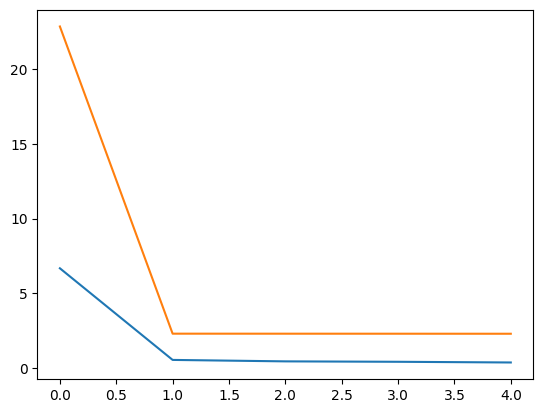

In [290]:
model = Net()
modelv2 = Netv2()

Train(model)
Train(modelv2)

In [299]:
def split(model, data):
    y_pred = model(data[0])
    loss = loss_fn(y_pred, data[1])
    # print(f"loss  : {loss.item()}")
    return loss
    

In [313]:
def translation_invariance(modelv1, modelv2):
    org_loss_v1 = split(modelv1,  (x_train, y_train))
    org_loss_v2 = split(modelv2,  (x_train, y_train))

    x = shift_min(x_train)
    min_loss_v1 = split(modelv1,  (x, y_train))
    min_loss_v2 = split(modelv2,  (x, y_train))

    x = shift_max(x_train)
    lar_loss_v1 = split(modelv1,  (x, y_train))
    lar_loss_v2 = split(modelv2,  (x, y_train))
    
    print("       models       :  modelv1: modelv2")
    print("\n")
    print(f"    Xtrain loss     : {org_loss_v1: .4f} : {org_loss_v2: .4f}")
    print("\n")
    print(f"org min shift loss  : {min_loss_v1: .4f} : {min_loss_v2: .4f}")
    print(f"diff min shift loss : {min_loss_v1-org_loss_v1: .4f} : {min_loss_v2-org_loss_v2: .4f}")
    print("\n")
    print(f"max shift loss      : {lar_loss_v1: .4f} : {lar_loss_v2: .4f}")
    print(f"diff max shift loss : {lar_loss_v1-org_loss_v1: .4f} : {lar_loss_v2-org_loss_v2: .4f}")



    

In [314]:
translation_invariance(model, modelv2)

       models       :  modelv1: modelv2


    Xtrain loss     :  0.3094 :  2.2922


org min shift loss  :  1.2328 :  2.2981
diff min shift loss :  0.9234 :  0.0059


max shift loss      :  1.4647 :  2.3010
diff max shift loss :  1.1553 :  0.0088


In [316]:
!dir

 Volume in drive D has no label.
 Volume Serial Number is 4882-5B27

 Directory of D:\jupyter_lab\cnn_tutorial

15-08-2024  15:14    <DIR>          .
15-08-2024  15:14    <DIR>          ..
12-08-2024  20:05    <DIR>          .ipynb_checkpoints
12-08-2024  20:24    <DIR>          Mnist_data
15-08-2024  15:14            37,244 tr_invar_equv.ipynb
               1 File(s)         37,244 bytes
               4 Dir(s)  227,999,113,216 bytes free
